# Pendulum
An Implementation of Reinforcement Learning
## Environment
- Changed the name of the private attribute `_get_obs()` to `get_obs()` in the original environment to enable evaluations.
- Modified `render()` function to output image RGB array.
- As an optional constrain, `inspect()` returns $0$ when the pendulum is below the horizen, meaning a damage $d=1$ is detected, while $1$ is returned otherwise.

In [1]:
import logging
import os
from math import pi

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from agent import DDPGAgent, DQNAgent, AssuredDQNAgent, JudgeAgent, TrigramJudgeAgent
from environment import MAX_SPEED
from framework import train, train_with_inspect

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
logging.basicConfig(level="WARNING")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Agent
### Deep Deterministic Policy Gradient

In [3]:
agent_ddpg = DDPGAgent(device)
score_ddpg = train(agent_ddpg, "DDPG", num_episodes=1000)

### Deep Q Network

In [4]:
agent_dqn = DQNAgent(device)
score_dqn = train(agent_dqn, "DQN", num_episodes=1000)

### Judge Module

In [5]:
agent_judge = JudgeAgent(device)
score_judge = train_with_inspect(agent_judge, "Judge", num_episodes=100000)

### Trigram Judge Module

In [6]:
agent_trigram_judge = TrigramJudgeAgent(device)
score_trigram_judge = train_with_inspect(agent_trigram_judge, "TrigramJudge", num_episodes=100000)

### DQN with Penalty

In [7]:
judge_trigram = agent_trigram_judge.judge
# judge_trigram = TrigramJudgeAgent(device, model_path="model/TrigramJudge.judge").judge
agent_dqn_penalty = AssuredDQNAgent(device)
score_dqn_penalty = train_with_inspect(agent_dqn_penalty, "DQN_Penalty", num_episodes=10000, judge=judge_trigram)

### DQN with Barrier

In [8]:
judge = agent_judge.judge
# judge = JudgeAgent(device, model_path="model/Judge.judge").judge
agent_dqn_barrier = AssuredDQNAgent(device, judge=judge)
score_dqn_barrier = train_with_inspect(agent_dqn_barrier, "DQN_Barrier", num_episodes=10000, judge=judge)

### DQN with Trigram Barrier

In [9]:
agent_dqn_trigram_barrier = AssuredDQNAgent(device, judge=judge_trigram)
score_dqn_trigram_barrier = train_with_inspect(agent_dqn_trigram_barrier, "DQN_TrigramBarrier", num_episodes=10000, judge=judge_trigram)

## Analysis

In [10]:
if not os.path.isdir("image"):
    os.mkdir("image")

### Judge Boundary

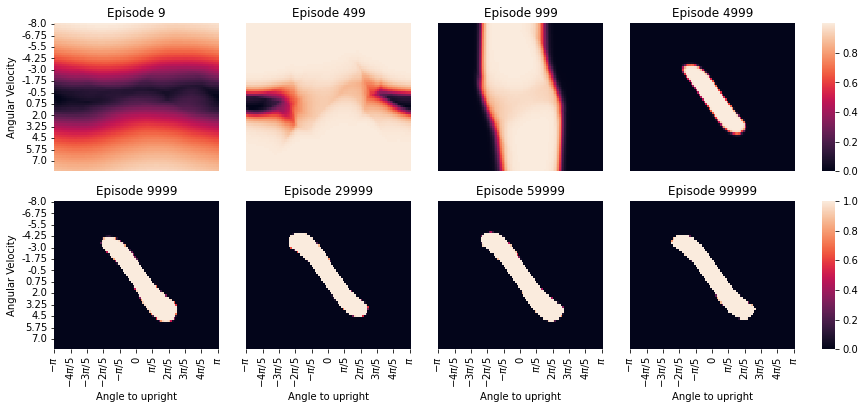

In [12]:
Theta = torch.linspace(-pi, pi, 101)
Omega = torch.linspace(-MAX_SPEED, MAX_SPEED, 65)
X = torch.cos(Theta)
Y = torch.sin(Theta)
episodes = [9, 499, 999, 4999, 9999, 29999, 59999, 99999]
fig, axes = plt.subplots(2, 5, figsize=(14, 6), gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
judge = JudgeAgent(device).judge
for i in range(len(episodes)):
    judge.load_state_dict(torch.load(f"resource/Judge/{episodes[i]}.judge"))
    judge.eval()
    data = {}
    for theta in Theta:
        states = torch.vstack([torch.cos(theta) * torch.ones(65), torch.sin(theta) * torch.ones(65), -Omega]).T.to(device)
        ds = judge(states).cpu()
        data[theta.item()] = torch.max(ds, axis=1).values.detach().numpy()
    data = pd.DataFrame(data, index=(Omega).tolist())
    if i % 4 == 3:
        plot = sns.heatmap(data, ax=axes[i//4, 3], cbar_ax=axes[i//4, 4])
    else:
        plot = sns.heatmap(data, cbar=False, ax=axes[i//4, i%4])
    if i % 4 == 0:
        plot.set_ylabel("Angular Velocity")
    else:
        plot.set_yticks([])
    if i >= 4:
        plot.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        plot.set_xticklabels(['$-\pi$','$-4\pi\slash5$', '$-3\pi\slash5$', '$-2\pi\slash5$', '$-\pi\slash5$', '0', 
                              '$\pi\slash5$', '$2\pi\slash5$','$3\pi\slash5$', '$4\pi\slash5$', '$\pi$'])
        plot.set_xlabel("Angle to upright")
    else:
        plot.set_xticks([])
    plot.set_title(f"Episode {episodes[i]}")
plt.savefig('image/judge_boundary.png', bbox_inches='tight')
plt.show()

### Trigram Judge Boundary

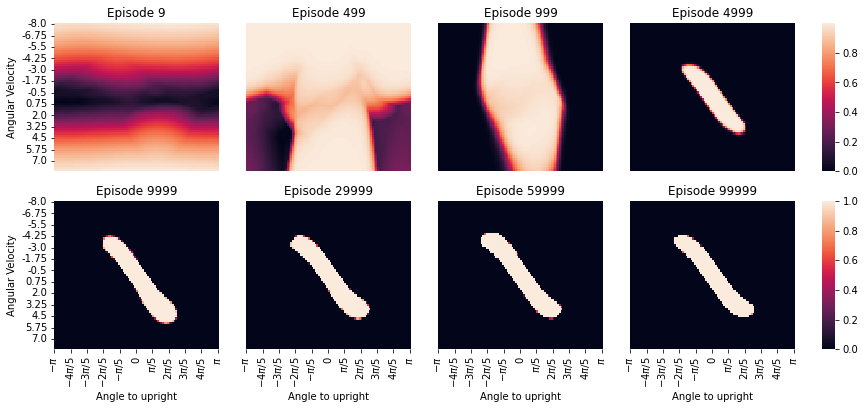

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(14, 6), gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
judge_trigram = TrigramJudgeAgent(device).judge
for i in range(len(episodes)):
    judge_trigram.load_state_dict(torch.load(f"resource/TrigramJudge/{episodes[i]}.judge"))
    judge_trigram.eval()
    data = {}
    for theta in Theta:
        states = torch.vstack([torch.cos(theta) * torch.ones(65), torch.sin(theta) * torch.ones(65), -Omega]).T.to(device)
        ds = judge_trigram(states).cpu()
        data[theta.item()] = torch.max(ds, axis=1).values.detach().numpy()
    data = pd.DataFrame(data, index=(Omega).tolist())
    if i % 4 == 3:
        plot = sns.heatmap(data, ax=axes[i//4, 3], cbar_ax=axes[i//4, 4])
    else:
        plot = sns.heatmap(data, cbar=False, ax=axes[i//4, i%4])
    if i % 4 == 0:
        plot.set_ylabel("Angular Velocity")
    else:
        plot.set_yticks([])
    if i >= 4:
        plot.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        plot.set_xticklabels(['$-\pi$','$-4\pi\slash5$', '$-3\pi\slash5$', '$-2\pi\slash5$', '$-\pi\slash5$', '0', 
                              '$\pi\slash5$', '$2\pi\slash5$','$3\pi\slash5$', '$4\pi\slash5$', '$\pi$'])
        plot.set_xlabel("Angle to upright")
    else:
        plot.set_xticks([])
    plot.set_title(f"Episode {episodes[i]}")
plt.savefig('image/trigram_judge_boundary.png', bbox_inches='tight')
plt.show()

### Comparison of Judge Module

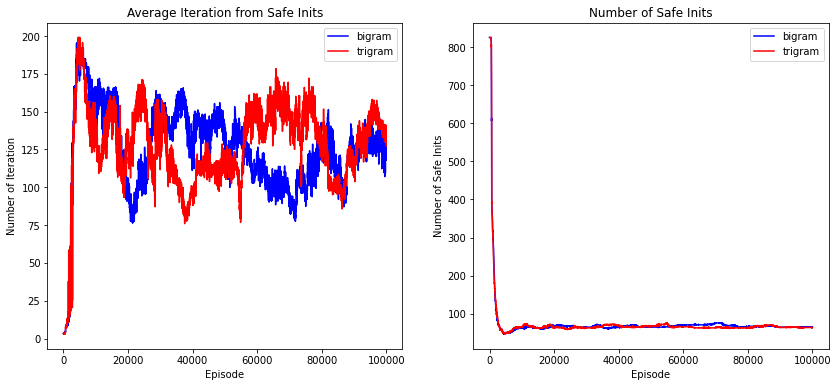

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(score_judge.scores["Episode"], score_judge.scores["Average Iteration from Safe Inits"], 'b-', label='bigram')
axes[0].plot(score_trigram_judge.scores["Episode"], score_trigram_judge.scores["Average Iteration from Safe Inits"], 'r-', label='trigram')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Number of Iteration')
axes[0].legend()
axes[0].set_title('Average Iteration from Safe Inits')
axes[1].plot(score_judge.scores["Episode"], score_judge.scores["Number of Safe Inits"], 'b-', label='bigram')
axes[1].plot(score_trigram_judge.scores["Episode"], score_trigram_judge.scores["Number of Safe Inits"], 'r-', label='trigram')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Number of Safe Inits')
axes[1].legend()
axes[1].set_title('Number of Safe Inits')
plt.savefig('image/comparison_of_judge_module.png', bbox_inches='tight')
plt.show()

### Comparison of Deep Q Network

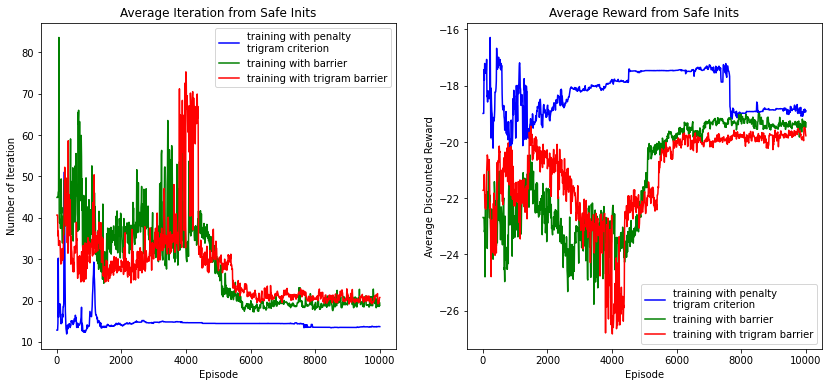

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(score_dqn_penalty.scores["Episode"], score_dqn_penalty.scores["Average Iteration from Safe Inits"], 'b-', label='training with penalty\ntrigram criterion')
axes[0].plot(score_dqn_barrier.scores["Episode"], score_dqn_barrier.scores["Average Iteration from Safe Inits"], 'g-', label='training with barrier')
axes[0].plot(score_dqn_trigram_barrier.scores["Episode"], score_dqn_trigram_barrier.scores["Average Iteration from Safe Inits"], 'r-', label='training with trigram barrier')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Number of Iteration')
axes[0].legend()
axes[0].set_title('Average Iteration from Safe Inits')
axes[1].plot(score_dqn_penalty.scores["Episode"], score_dqn_penalty.scores["Average Reward from Safe Inits"], 'b-', label='training with penalty\ntrigram criterion')
axes[1].plot(score_dqn_barrier.scores["Episode"], score_dqn_barrier.scores["Average Reward from Safe Inits"], 'g-', label='training with barrier')
axes[1].plot(score_dqn_trigram_barrier.scores["Episode"], score_dqn_trigram_barrier.scores["Average Reward from Safe Inits"], 'r-', label='training with trigram barrier')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Average Discounted Reward')
axes[1].legend()
axes[1].set_title('Average Reward from Safe Inits')
plt.savefig('image/comparison_of_deep_q_network.png', bbox_inches='tight')
plt.show()